In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

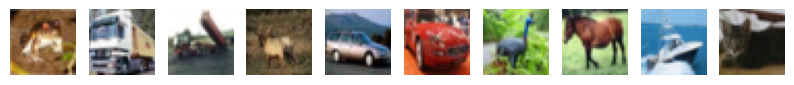

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [15]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [14]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-traina

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, frequency='epoch', save_weights_only=True,
                             verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 1.9787 - accuracy: 0.2729
Epoch 1: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 9s 26ms/step - loss: 1.9787 - accuracy: 0.2729
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.6160 - accuracy: 0.4206
Epoch 2: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 11s 36ms/step - loss: 1.6156 - accuracy: 0.4209
Epoch 3/3
312/313 [============================>.] - ETA: 0s - loss: 1.4658 - accuracy: 0.4751
Epoch 3: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 11s 35ms/step - loss: 1.4655 - accuracy: 0.4751


In [11]:
# Have a look at what the checkpoint creates

! dir -a model_checkpoints

 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials\model_checkpoints

12/27/2023  12:14 PM    <DIR>          .
12/27/2023  12:11 PM    <DIR>          ..
12/27/2023  12:14 PM                77 checkpoint
12/27/2023  12:14 PM           178,045 checkpoint.data-00000-of-00001
12/27/2023  12:14 PM             2,038 checkpoint.index
               3 File(s)        180,160 bytes
               2 Dir(s)  327,631,953,920 bytes free


File Not Found


In [12]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.489


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.096


In [14]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.489


#### Clear directory

In [15]:
! rd /S /Q model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_5000_path = \
    'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(checkpoint_5000_path, save_weights_only=True, save_freq=5000, verbose=1)

In [18]:
# Create and fit model with checkpoint

model=get_new_model()
model.fit(x_train,y_train, epochs=3, validation_data=(x_test,y_test),
          batch_size=10,
          callbacks=[checkpoint_5000])

Epoch 1/3
1000/1000 [==============================] - 17s 17ms/step - loss: 1.8753 - accuracy: 0.3075 - val_loss: 1.6761 - val_accuracy: 0.3860
Epoch 2/3
1000/1000 [==============================] - 18s 18ms/step - loss: 1.4929 - accuracy: 0.4602 - val_loss: 1.4309 - val_accuracy: 0.4810
Epoch 3/3
1000/1000 [==============================] - 16s 16ms/step - loss: 1.3605 - accuracy: 0.5166 - val_loss: 1.3839 - val_accuracy: 0.5130


In [19]:
# Have a look at what the checkpoint creates

! dir -a model_checkpoint

 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials



File Not Found


#### Work with model saving criteria

In [20]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [21]:
# Create a new instance of untrained model

model= get_new_model()

In [22]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(checkpoint_best_path, save_weights_only=True, save_freq='epoch',save_best_only=True, monitor='val_accuracy', verbose=1)

In [23]:
# Fit the model and save only the weights with the highest validation accuracy
history=model.fit(x_train,y_train, epochs=50,validation_data=(x_test,y_test),batch_size=10,callbacks=[checkpoint_best],verbose=0)



Epoch 1: val_accuracy improved from -inf to 0.06000, saving model to model_checkpoints_best\checkpoint

Epoch 2: val_accuracy improved from 0.06000 to 0.13000, saving model to model_checkpoints_best\checkpoint

Epoch 3: val_accuracy did not improve from 0.13000

Epoch 4: val_accuracy did not improve from 0.13000

Epoch 5: val_accuracy did not improve from 0.13000

Epoch 6: val_accuracy did not improve from 0.13000

Epoch 7: val_accuracy did not improve from 0.13000

Epoch 8: val_accuracy did not improve from 0.13000

Epoch 9: val_accuracy improved from 0.13000 to 0.14000, saving model to model_checkpoints_best\checkpoint

Epoch 10: val_accuracy did not improve from 0.14000

Epoch 11: val_accuracy did not improve from 0.14000

Epoch 12: val_accuracy did not improve from 0.14000

Epoch 13: val_accuracy did not improve from 0.14000

Epoch 14: val_accuracy did not improve from 0.14000

Epoch 15: val_accuracy improved from 0.14000 to 0.16000, saving model to model_checkpoints_best\checkpoi

<AxesSubplot:>

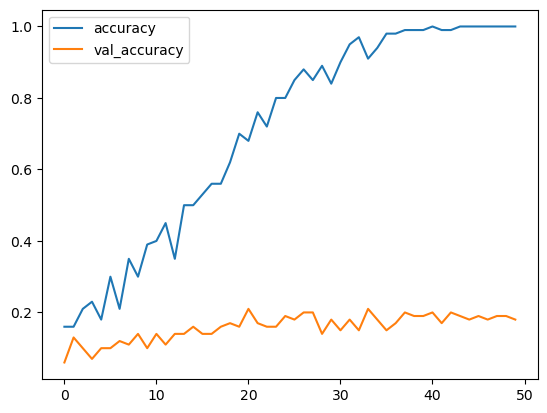

In [24]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [55]:
# Inspect the checkpoint directory
! dir -a model_checkpoint_bestt


 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials



File Not Found


In [56]:
# Create a new model with the saved weights

new_model=get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.210


#### Clear directory

In [57]:
! rd /S /Q model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [59]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=False, save_freq='epoch', verbose=1)

In [60]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train,y_train, epochs=3,callbacks=[checkpoint])


Epoch 1/3
4/4 [==============================] - ETA: 0s - loss: 2.3096 - accuracy: 0.1000
Epoch 1: saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


4/4 [==============================] - 2s 516ms/step - loss: 2.3096 - accuracy: 0.1000
Epoch 2/3
3/4 [=====================>........] - ETA: 0s - loss: 2.2853 - accuracy: 0.1875
Epoch 2: saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


4/4 [==============================] - 1s 418ms/step - loss: 2.2846 - accuracy: 0.1900
Epoch 3/3
1/4 [======>.......................] - ETA: 0s - loss: 2.2692 - accuracy: 0.1562
Epoch 3: saving model to model_checkpoint


INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


4/4 [==============================] - 1s 453ms/step - loss: 2.2675 - accuracy: 0.1600


#### Inspect what the checkpoint has created

In [61]:
# Have a look at what the checkpoint creates

! dir -a model_checkpoint

 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials\model_checkpoint

12/27/2023  12:22 PM    <DIR>          .
12/27/2023  12:22 PM    <DIR>          ..
12/27/2023  12:22 PM    <DIR>          assets
12/27/2023  12:22 PM            14,483 keras_metadata.pb
12/27/2023  12:22 PM           125,340 saved_model.pb
12/27/2023  12:22 PM    <DIR>          variables
               2 File(s)        139,823 bytes
               4 Dir(s)  326,001,512,448 bytes free


File Not Found


In [69]:
# Enter variables directory
! dir -a variables


 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials



File Not Found


In [70]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.060


#### Create new model from scratch

In [71]:
# Delete model
del model


In [72]:
from tensorflow.keras.models import load_model

In [74]:
# Reload model from scratch
model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)


accuracy: 0.060


#### Use the .h5 format to save model

In [75]:
# Save the model in .h5 format
model.save('my_model.h5')


In [77]:
# Inspect .h5 file
!dir -a my_model.h5

 Volume in drive C is OS
 Volume Serial Number is DEF0-267E

 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials


 Directory of c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials

12/27/2023  12:26 PM            79,432 my_model.h5
               1 File(s)         79,432 bytes
               0 Dir(s)  325,999,251,456 bytes free


In [78]:
# Delete model
del model


In [80]:
# Reload model from scratch

model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


#### Clear directory

In [83]:
! rd /S /Q model_checkpoints
! del my_model.h5

The system cannot find the file specified.


Could Not Find c:\Users\krute\OneDrive\Desktop\Tensorflow2\Files\Files\home\jovyan\work\4\tutorials\my_model.h5


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [2]:
from tensorflow.keras.models import load_model

In [3]:
# Build Keras ResNet50 model
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')


#### Import and preprocess 3 sample images

In [4]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [5]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds


##### Image 1: lemon

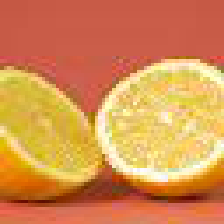

In [6]:
# Display image

lemon_img

In [7]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)


1/1 [==============================] - 1s 1s/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.040088
5,spotlight,0.029197


##### Image 2: viaduct

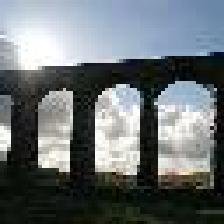

In [8]:
# Display image
viaduct_img


In [9]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 141ms/step


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.088231
5,fire_screen,0.020675


##### Image 3: water tower

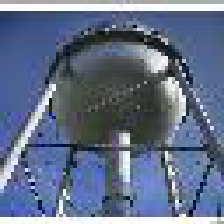

In [10]:
# Display image
water_tower_img


In [11]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 138ms/step


,prediction,probability
1,solar_dish,0.384682
2,ladle,0.196178
3,planetarium,0.116683
4,strainer,0.04999
5,jigsaw_puzzle,0.021947


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [12]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [16]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [17]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [18]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [19]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

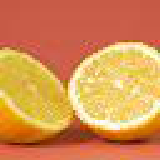

In [20]:
lemon_img

In [21]:
get_top_5_predictions(lemon_img)

1/1 [==============================] - 0s 261ms/step


,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

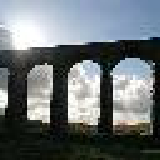

In [22]:
viaduct_img

In [23]:
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 27ms/step


,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

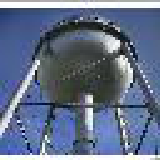

In [24]:
water_tower_img

In [25]:
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 34ms/step


,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
